In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import commonfunc

In [5]:
data_set_path = "./sampled_data_csv_100/"

# Outputevents

## Read samples

In [27]:
outputevents_df = commonfunc.read_csv_no_rowid(data_set_path + "outputevents.csv")

In [28]:
outputevents_df = outputevents_df.sample(1400)

In [29]:
outputevents_df.head()

,subject_id,hadm_id,icustay_id,charttime,itemid,value,valueuom,storetime,cgid,stopped,newbottle,iserror
5827,11658,154944,227993.0,2180-11-12 14:00:00,40055,45.0,ml,2180-11-12 14:16:00,17746,NaN,NaN,NaN
144,21269,109697,241691.0,2162-12-01 18:00:00,40055,200.0,ml,2162-12-01 17:52:00,14387,NaN,NaN,NaN
6182,11003,108797,268364.0,2119-05-21 20:00:00,40055,60.0,ml,2119-05-21 20:18:00,21050,NaN,NaN,NaN
3655,25080,154198,260285.0,2168-01-03 14:00:00,40055,35.0,ml,2168-01-03 15:03:00,17013,NaN,NaN,NaN
5335,1709,176360,215498.0,2116-03-05 12:00:00,40055,300.0,ml,2116-03-05 12:09:00,15222,NaN,NaN,NaN


## Data pre-process

In [30]:
# outputevents_df.dropna(subset=['hadm_id'], inplace=True, axis=0)
# outputevents_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [31]:
outputevents_df.drop(['valueuom', 'storetime', 'cgid', 'stopped', 'newbottle', 'iserror'], axis=1, inplace=True)

### Process missing values

In [32]:
commonfunc.nan_count(outputevents_df)

Total columns: 6
Total rows: 1400
--------------
subject_id     0
hadm_id        0
icustay_id     2
charttime      0
itemid         0
value         29
dtype: int64


In [33]:
outputevents_df.dropna(subset=['value'], inplace=True, axis=0)

In [34]:
commonfunc.nan_count(outputevents_df)

Total columns: 6
Total rows: 1371
--------------
subject_id    0
hadm_id       0
icustay_id    2
charttime     0
itemid        0
value         0
dtype: int64


### Set the column types

In [35]:
outputevents_df.dtypes

subject_id      int64
hadm_id         int64
icustay_id    float64
charttime      object
itemid          int64
value         float64
dtype: object

In [36]:
outputevents_df['charttime'] = pd.to_datetime(outputevents_df['charttime'])

In [37]:
outputevents_df.dtypes

subject_id             int64
hadm_id                int64
icustay_id           float64
charttime     datetime64[ns]
itemid                 int64
value                float64
dtype: object

### Process time value

In [38]:
icustays_df = commonfunc.read_csv_no_rowid(data_set_path+"icustays.csv")

In [39]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [40]:
outputevents_mid_df = pd.merge(left=outputevents_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [41]:
outputevents_mid_df.dtypes

subject_id             int64
hadm_id                int64
icustay_id           float64
charttime     datetime64[ns]
itemid                 int64
value                float64
intime        datetime64[ns]
dtype: object

In [43]:
outputevents_mid_df['charttime'] = outputevents_mid_df.apply(commonfunc.time_process, args=('intime', 'charttime'), axis=1)
outputevents_mid_df = outputevents_mid_df.dropna(subset=['charttime'])
outputevents_mid_df['charttime'] = outputevents_mid_df['charttime'].astype(np.int64)

TypeError: unsupported operand type(s) for -: 'float' and 'Timestamp'

In [44]:
outputevents_df = outputevents_mid_df.drop(['subject_id', 'hadm_id', 'icustay_id', 'intime'], axis=1)

In [45]:
outputevents_df.columns

Index(['charttime', 'itemid', 'value'], dtype='object')

---
## Build model

### Set constraints

In [46]:
from sdv.constraints import FixedCombinations

fixed_item_value_linkorderid_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [47]:
constraints = [fixed_item_value_linkorderid_constraint]

### Build model

In [49]:
train_data = outputevents_df
best_model = commonfunc.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 46117.87it/s]

Gaussian Copula



Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 45056.58it/s]

CTGAN



Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 13707.66it/s]


CopulaGAN


Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 16940.07it/s]


TVAE


Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 18836.26it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 54749.98it/s]


The best model is: copulagan
The ContinuousKL_score is: 0.6589593682816212
The DiscreteKL_score is: nan
The total score is: 0.5669223356975606


In [51]:
model_save_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "outputevents_model.pkl"
commonfunc.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [53]:
date_load_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "outputevents_model.pkl"
model = commonfunc.load_model(date_load_path)

In [55]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 1371/1371 [00:00<00:00, 28793.42it/s]


### Evaluation

In [56]:
from sdv.evaluation import evaluate

In [57]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.6672653975852204

In [58]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [59]:
evaluate(sample, train_data, metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence'])

0.7643402115570157

<Axes: >

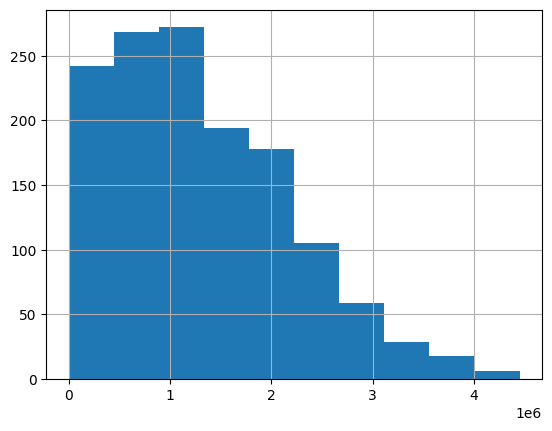

In [60]:
sample['charttime'].hist()

<Axes: >

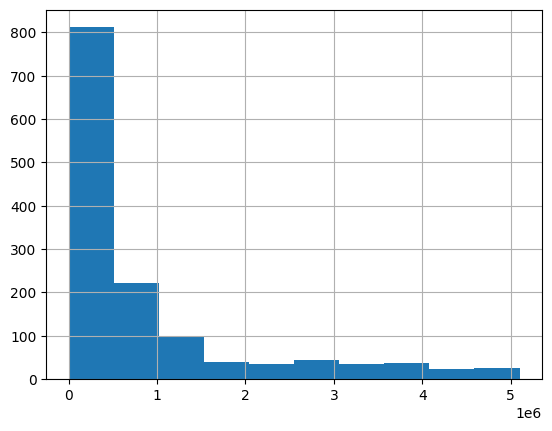

In [61]:
train_data['charttime'].hist()

array([[<Axes: title={'center': 'charttime'}>,
        <Axes: title={'center': 'itemid'}>],
       [<Axes: title={'center': 'value'}>, <Axes: >]], dtype=object)

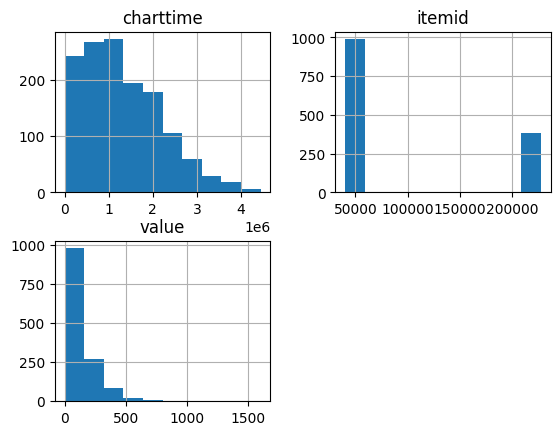

In [62]:
sample.hist()

array([[<Axes: title={'center': 'charttime'}>,
        <Axes: title={'center': 'itemid'}>],
       [<Axes: title={'center': 'value'}>, <Axes: >]], dtype=object)

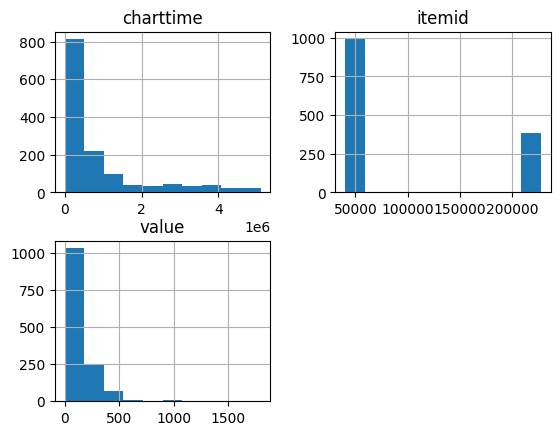

In [63]:
train_data.hist()

<Axes: xlabel='itemid', ylabel='value'>

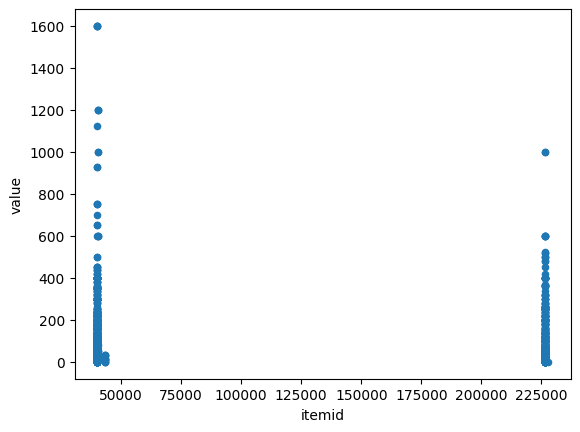

In [64]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<Axes: xlabel='itemid', ylabel='value'>

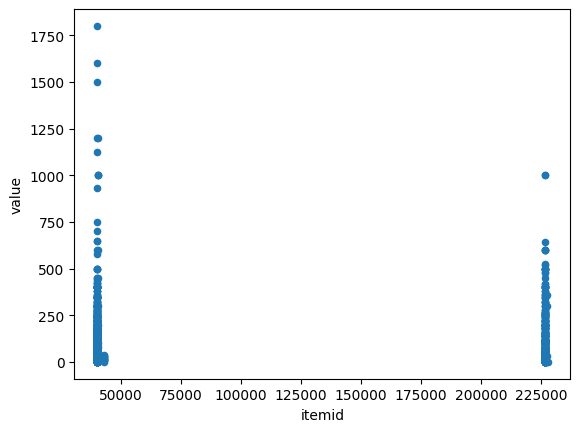

In [65]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')